In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
#Load the data.
train = pd.read_json("input/train.json")
test = pd.read_json("input/test.json")

In [3]:
from IPython.display import display
# display datasets
display(train.head())
display(test.head())

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [4]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [5]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [6]:
target_train=train['is_iceberg']
print(target_train[0:10])

0    0
1    0
2    1
3    0
4    0
5    1
6    1
7    0
8    0
9    0
Name: is_iceberg, dtype: int64


In [7]:
plotmy3d(X_band_1[5,:,:], 'iceberg - HH')
plotmy3d(X_band_2[5,:,:], 'iceberg - HV')
target_train[5]
plotmy3d(X_band_1[3,:,:], 'ship - HH')
plotmy3d(X_band_2[3,:,:], 'ship - HV')
target_train[3]

0

In [8]:
plotmy3d(X_band_1[2,:,:], 'iceberg - HH')
plotmy3d(X_band_2[2,:,:], 'iceberg - HV')
target_train[2]

1

---


In [9]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

/Users/jeongwhanchoi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [10]:
#define our model
def getModel():
    #Building the model
    model=Sequential()
    #Conv Layer 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    #Conv Layer 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #Conv Layer 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #Conv Layer 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    model.add(Flatten())

    #Dense Layers
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    #Dense Layer 2
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    #Sigmoid Layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    model.summary()
    return model

In [11]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [12]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

/Users/jeongwhanchoi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [13]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# model=getModel()
# SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

In [14]:
# import pydot
# from keras.utils import plot_model
# plot_model(model, to_file='model00.png')

---

In [15]:
model=getModel()
model.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=30,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [19]:
model.load_weights(filepath=file_path)
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])

401/401 [==============================] - 3s 8ms/step
Validation score: 0.2745435646644554
Validation accuracy: 0.8703241902693846


In [17]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=model.predict_proba(X_test)

In [18]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub-model_00.csv', index=False)

---

In [20]:
X_test

array([[[[-15.863251, -21.629612, -18.746431],
         [-15.201077, -21.142353, -18.171715],
         [-17.887735, -23.908337, -20.898037],
         ...,
         [-14.146514, -23.479631, -18.813072],
         [-12.898778, -24.123251, -18.511015],
         [-14.006273, -26.40205 , -20.204163]],

        [[-16.395206, -20.985918, -18.690563],
         [-15.201077, -21.142353, -18.171715],
         [-16.395063, -26.701574, -21.548319],
         ...,
         [-15.438498, -26.696655, -21.067577],
         [-14.006346, -23.075493, -18.54092 ],
         [-13.73268 , -25.574196, -19.653439]],

        [[-15.443562, -23.90848 , -19.676022],
         [-14.365982, -23.908407, -19.137196],
         [-17.059881, -25.579258, -21.319569],
         ...,
         [-17.054962, -24.123323, -20.589142],
         [-15.35687 , -23.075493, -19.21618 ],
         [-13.800274, -24.348803, -19.07454 ]],

        ...,

        [[-14.586817, -25.580256, -20.083536],
         [-17.160078, -23.909264, -20.534672]

In [26]:
min = np.min(X_train)
max = np.max(X_train)
diff = max - min
my_sum = lambda x: (x - min)/diff

In [32]:
print(min, max)
print (my_sum)

-45.6555 34.574917
<function <lambda> at 0x187d73b70>


In [33]:
X_holdout2 = my_sum(X_train)

In [34]:
X_holdout2.shape

(1604, 75, 75, 3)

In [36]:
pred_valid = predicted_test.reshape((predicted_test.shape[0]))

In [55]:
def pred(i):
    plt.imshow(X_holdout2[i], cmap='gray', interpolation='nearest');
    tl = "Actual label : " +str(target_train[i])+ ","+" iceberg_probability : "+str(pred_valid[i])
    plt.title(tl)

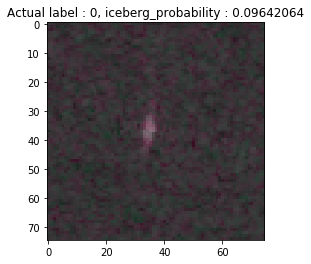

In [62]:
pred(0)

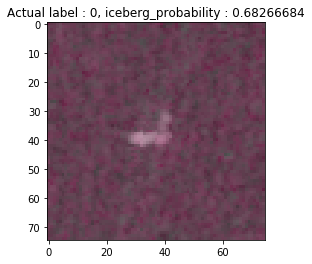

In [63]:
pred(1)

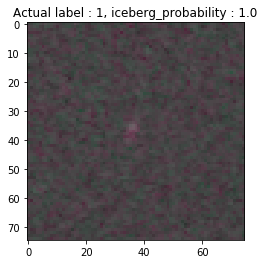

In [64]:
pred(2)

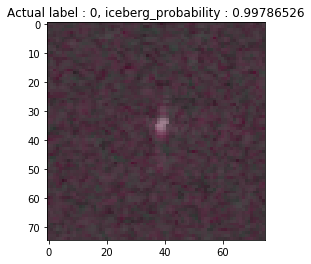

In [65]:
pred(3)

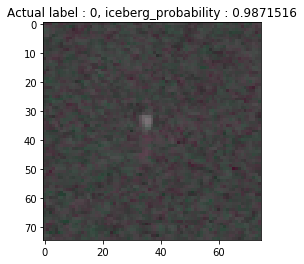

In [66]:
pred(4)